In [99]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple

from tsp import TSP
from solvers import AntSolver, AntSystemSolver
from visualization import *

# Solvers

In [1]:
class AntColonySystemSolver(AntSolver):
    """
    Ant Colony System (ACS) is an extension of the Ant System algorithm speciallized in
    solving TSPs with improved efficiency. This algorithm has three main differences from
    the Ant System algorithm:

    1.  A different transition probability function which provides a direct way to balance 
        between exploration of new edges, and exploitation of a priori and accumulated knowledge.

    2.  The global pheromone update rule is applied only to the edges of the best tour 
        found so far.

    3.  A local pheromone update rule is applied to all edges while ants build a solution.
    """
    def __init__(
        self, 
        *args,
        rho=0.1, # pheromone decay in local update
        q0=0.9, # probability of choosing the greedy strategy
        **kwargs
        ):
        super().__init__(*args, **kwargs)
        self.rho = rho
        self.q0 = q0

    def _acs_transition_probability(self, ant, visited_cities):
        if np.random.rand() < self.q0:
            # exploit
            probs = self.pheromones[visited_cities[-1]] ** self.alpha * self.instance.get_heuristic(visited_cities[-1]) ** self.beta
            probs[visited_cities] = 0
            probs /= probs.sum()
            return probs
        else:
            # explore
            probs = self.pheromones[visited_cities[-1]] ** self.alpha * self.instance.get_heuristic(visited_cities[-1]) ** self.beta
            probs[visited_cities] = 0
            probs /= probs.sum()
            return probs
    
    def sample(
        self,
        n_tours=None,
        strategy='stochastic'
        ):
        assert n_tours is None or n_tours <= self.n_ants, 'Sampling for n_tours > n_ants is not supported'
        if n_tours is None:
            n_tours = self.n_ants

        starting_positions = self._initialize_ants(n_tours)
        
        tours = []
        for ant in range(n_tours):
            initial_position = starting_positions[ant]
            visited_cities = [initial_position]
            default_probabilities = self._transition_probability(initial_position, visited_cities=visited_cities)

            for i in range(self.n_cities-1): 
                if np.random.rand() < self.q0:
                    # exploit
                    probs = self.pheromones[visited_cities[-1]] ** self.alpha * self.instance.get_heuristic(visited_cities[-1]) ** self.beta
                    probs[visited_cities] = 0
                    probs /= probs.sum()
                    return probs
                else:
                    # explore
                    probs = self.pheromones[visited_cities[-1]] ** self.alpha * self.instance.get_heuristic(visited_cities[-1]) ** self.beta
                    probs[visited_cities] = 0
                    probs /= probs.sum()
                    return probs

            starting_position = starting_positions[ant]
            probs = self._acs_transition_probability(starting_position, visited_cities=[starting_position])
            
            if strategy == 'stochastic':
                tour = np.concatenate(([starting_position], np.random.choice(np.arange(self.n_cities), 
                                                                replace=False, size=self.n_cities-1, p=probs)))
            elif strategy == 'greedy':
                tour = np.concatenate(([starting_position], np.argsort(np.nonzero(probs))[0]))

            tours.append(tour)

        return np.array(tours)
    
    def update_pheromone(self, tours):
        tour_lengths = self.instance.get_cost(tours)

        """
        The for loop below calculates the delta_phero matrix for each of the k ants with the best tours.
        The delta_phero matrix has 1/tour_length[ant] in the position (i, j) if the ant visited the city j after the city i
        and 0 otherwise.
        """
        delta_pheros = np.zeros((self.n_ants, self.n_cities, self.n_cities))
        for ant in range(self.n_ants):
            tour = tours[ant]
            tour = np.concatenate((tour, [tour[0]])) # the ant returns to the starting city
            edges = np.array([[city, next_city] for city, next_city in zip(tour[:-1], tour[1:])])

            # the i-th element of the array below is the city visited after city i
            next_cities = edges[edges[:, 0].argsort()][:, 1]
            
            # scattering ones in the positions that correspond to edges walked by the ant
            values = np.ones(delta_pheros.shape[1])
            values[np.where(next_cities == tour[0])[0]] = 0 # discarding the edge which closes the loop
            np.put_along_axis(delta_pheros[ant], np.expand_dims(next_cities, 1), np.expand_dims(values, 1), axis=-1)
            delta_pheros[ant] = (delta_pheros[ant] + delta_pheros[ant].T) / tour_lengths[ant] # making the matrix symmetric and normalizing by the tour length

        # applying the pheromone update rule 
        self.pheromones = (1 - self.alpha) * self.pheromones + np.sum(delta_pheros, axis=0)

    def local_update_pheromone(self, edge: Tuple[int, int], strategy='Ant-Q'):
        if strategy == 'off':
            return
        assert strategy in ['Ant-Q', 'zero', 'ACS']

        delta_phero = {

        }
        

NameError: name 'AntSolver' is not defined

In [103]:
NUM_IT = 200

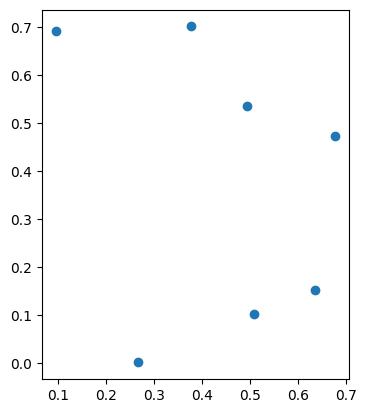

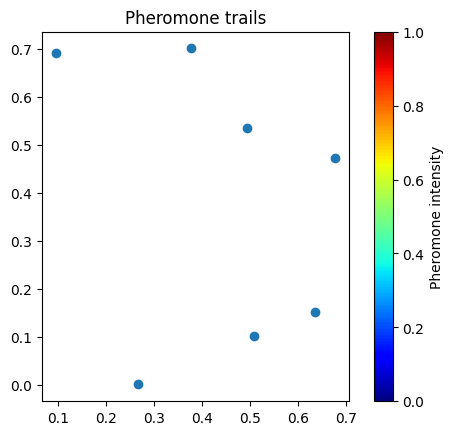

In [108]:
# debugging

# square
# cities = np.array([[2, 1], [2, 2], [1, 1], [1, 2]])
# tsp = TSP.from_instance(cities)

# circle
# cities = np.array([[0, 1], [0.25, 0.5], [0.3232, 0.3232], [0.5, 0.25], [0.6768, 0.3232], [0.75, 0.5], [1, 1]])
# tsp = TSP.from_instance(cities)

# random
tsp = TSP.random_instance(7)

solver = AntSystemSolver(tsp)

plot_solution(tsp.cities, save_dir=None)
plot_pheromone_trails(tsp.cities, solver.pheromones, save_dir=None)

--> Best tour so far: [6 0 5 2 3 4 1], cost: 1.6585610536084145, it: 0,
--> Best tour so far: [6 0 5 3 2 1 4], cost: 1.6226976431406779, it: 2,
--> Best tour so far: [4 1 2 3 5 0 6], cost: 1.6226976431406777, it: 11,
--> Best tour so far: [6 5 0 3 2 4 1], cost: 1.6193705766365825, it: 25,
--> Best tour so far: [1 4 2 3 5 0 6], cost: 1.3981964361006491, it: 52,


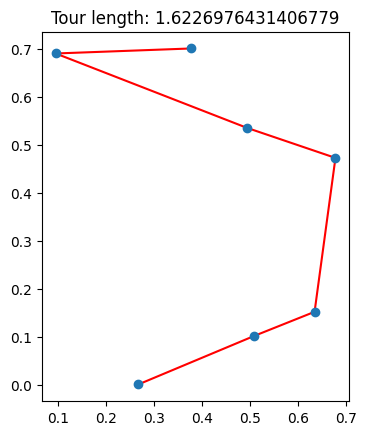

In [109]:
least_cost = np.inf
avg_costs = {
    'train': [],
    'val': []
}
for it in range(NUM_IT):
    # sampling a batch of solutions for training
    train_tours = solver.sample()
    train_costs = tsp.evaluate(train_tours)
    avg_costs['train'].append(np.mean(train_costs))

    # getting a batch of solutions using greedy strategy for validation
    val_tours = solver.sample(strategy='greedy')
    val_costs = tsp.evaluate(val_tours)
    avg_costs['val'].append(np.mean(val_costs))

    # selecting the best tour
    min_train_cost = np.min(train_costs)
    min_val_cost = np.min(val_costs)

    if min_train_cost < min_val_cost:
        best_tour = train_tours[np.argmin(train_costs)]
        min_cost = min_train_cost
    else:
        best_tour = val_tours[np.argmin(val_costs)]
        min_cost = min_val_cost

    if min_cost < least_cost:
        least_cost = min_cost
        print(f'--> Best tour so far: {best_tour}, cost: {least_cost}, it: {it},')
    
    # plotting
    if it % 10 == 0:
        plot_solution(tsp.cities, val_tours[np.argmin(val_costs)], np.min(val_costs), save_dir=f'results/tours/tour_{it}')
        plot_pheromone_trails(tsp.cities, solver.pheromones, save_dir=f'results/pheromones/trails_{it}')
        #print(f'Iteration {it}: avg train cost: {avg_costs['train']}, avg val cost: {avg_costs['val']}')
        #plt.show()
        plt.close()
    
    # updating the pheromone matrix
    solver.update_pheromone(train_tours)

plot_mean_cost(avg_costs['val'], save_dir=f'results/costs/costs_{it}')
plt.close()